* Reference: https://github.com/nmhkahn/MemN2N-pytorch/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import init
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

from dataset import bAbIDataset
from tqdm import tqdm

# Configurations

In [2]:
dataset_dir = 'D:/jupyter/pytorch/DL-for-Chatbot-master/Day_04/memn2n/bAbl/en/'
task = 5 # 1 ~ 20 개의 task
max_hops = 3
batch_size = 10
max_epochs = 100
embedding_dim = 20
lr = 1e-2
max_clip = 40.0
decay_interval = 25
decay_ratio = 0.5
cuda = False

# Load bAbI dataset / dataloader

In [3]:
train_data = bAbIDataset(dataset_dir, 5)
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          num_workers=1,
                          shuffle=True)

C:\cosmos\envs\env1\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [4]:
test_data = bAbIDataset(dataset_dir, task, train=False)
test_loader = DataLoader(test_data,
                          batch_size=batch_size,
                          num_workers=1,
                          shuffle=False)

C:\cosmos\envs\env1\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [5]:
print('Epoch당 batch 개수', len(train_data))
print("최대 문장 길이", train_data.sentence_size)
print("최대 지문 문장 수", train_data.max_story_size)
print("평균 지문당 문장 수", train_data.mean_story_size)
print("Vocabulary 크기", train_data.num_vocab)

Epoch당 batch 개수 1000
최대 문장 길이 8
최대 지문 문장 수 102
평균 지문당 문장 수 19
Vocabulary 크기 90


## dataloader 의 출력:
    - story (지문): (LongTensor) [batch_size, 최대 문장 수, 최대 문장 길이]
    - query (문제): (LongTensor) [batch_size, 최대 문장 길이]
    - answer (정답): (LongTensor) [batch_size]

In [6]:
next(iter(train_loader))

[
 (0 ,.,.) = 
   23  37  33  ...    0   0  89
   11  34  31  ...    0   0  88
    5  35  33  ...    0   0  87
      ...       ⋱       ...    
   23  29   8  ...    0   0  42
    5  37   2  ...   26   0  41
   23  16  31  ...    0   0  40
 
 (1 ,.,.) = 
   11  34  31  ...    0   0  85
   19  25  33  ...    0   0  84
   11   7  31  ...    0   0  83
      ...       ⋱       ...    
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
 
 (2 ,.,.) = 
   23  25  33  ...    0   0  55
   19  37  33  ...    0   0  54
   19  20  33  ...    0   0  53
      ...       ⋱       ...    
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
 ...
 
 (7 ,.,.) = 
   19  15  31  ...    0   0  51
   19  25  33  ...    0   0  50
   19  28  36  ...   32   0  49
      ...       ⋱       ...    
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
 
 (8 ,.,.) = 
    5  37   2  ...    4 

# Positional Encoding

$ l_{kj} = (1−j/J)−(k/d)(1−2j/J) $

- k: 벡터의 몇 번째 원소인지
- j: 문장에서 몇 번째 단어인지
- J: 문장은 몇 개의 단어로 이루어져 있는지
- d: 벡터의 차원

In [7]:
def position_encoding(sentence_size, embedding_dim):
    encoding = np.ones((embedding_dim, sentence_size), dtype=np.float32)
    ls = sentence_size + 1
    le = embedding_dim + 1
    for i in range(1, le):
        for j in range(1, ls):
            encoding[i-1, j-1] = (i - (embedding_dim+1)/2) * (j - (sentence_size+1)/2)
    encoding = 1 + 4 * encoding / embedding_dim / sentence_size
    # Make position encoding of time words identity to avoid modifying them
    encoding[:, -1] = 1.0
    return np.transpose(encoding)

In [8]:
position_encoding(3,4)

array([[1.5      , 1.1666666, 0.8333333, 0.5      ],
       [1.       , 1.       , 1.       , 1.       ],
       [1.       , 1.       , 1.       , 1.       ]], dtype=float32)

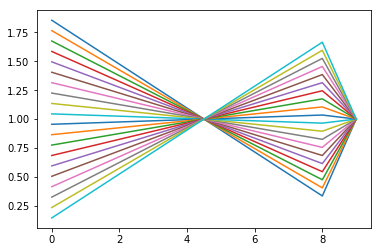

In [9]:
plt.plot(position_encoding(10,20))
plt.show()

# (Advanced) To use list of nn.Module in a nn.Module

In [10]:
class AttrProxy(object):
    """
    Translates index lookups into attribute lookups.
    To implement some trick which able to use list of nn.Module in a nn.Module
    see https://discuss.pytorch.org/t/list-of-nn-module-in-a-nn-module/219/2
    """
    def __init__(self, module, prefix):
        self.module = module
        self.prefix = prefix

    def __getitem__(self, i):
        return getattr(self.module, self.prefix + str(i))

# Model

In [18]:
class MemN2N(nn.Module):
    def __init__(self, use_cuda=False, num_vocab=32, embedding_dim=20, sentence_size=7, max_hops=3):
        super(MemN2N, self).__init__()
        
        # Weight Tying Type => Adjacent
        # Embedding matrix C
        # W_T = C_K (최종 출력은 embedding은 C와 공유)
        # B = A_1 (질문 embedding은 C와 공유)
        # A_k+1 = C_k (이전 출력 embedding은 입력 embedding과 같음)
        # => 결국 embedding matrix는 attention hop 마다 하나만 존재
        for hop in range(max_hops+1):
            C = nn.Embedding(num_vocab, embedding_dim, padding_idx=0)
            C.weight.data.normal_(0, 0.1)
            self.add_module("C_{}".format(hop), C)
        
        # 아래와 같이 nn.Module 의 attribute로 list of nn.Module를 추가하기 위한 우회적 방법
        # MemN2N (
        #   (C_0): Embedding(30, 20, padding_idx=0)
        #   (C_1): Embedding(30, 20, padding_idx=0)
        #   (C_2): Embedding(30, 20, padding_idx=0)
        #   (C_3): Embedding(30, 20, padding_idx=0)
        #   (softmax): Softmax ()
        # )
        # self.C: list of nn.Embedding of each hop
        self.C = AttrProxy(self, "C_")

        self.softmax = nn.Softmax()
        
        # Positional Encoding
        # 파라미터에 따라 변하는 값이 아니라 단어의 위치에 따라 변하는 값이므로, backpropagation 불필요
        # [최대 문장 길이, embedding_dim]
        self.encoding = Variable(torch.FloatTensor(
            position_encoding(sentence_size, embedding_dim)), requires_grad=False)
        
        self.max_hops = max_hops

        if use_cuda:
            self.encoding = self.encoding.cuda()

    def forward(self, story, query):
        """
        Args:        
            story: [batch_size, 최대 문장 수, 최대 문장 길이]
            query: [batch_size, 최대 문장 길이]
        Return:
            a_hat: [batch_size] # => for training
            # softmax(a_hat): [batch_size] => for evaluation
        """
        
        story_size = story.size()
        batch_size = story_size[0]


        # Query Embedding
        B = self.C[0]
        # query: [batch_size, 최대 문장 길이]
        # => [batch_size, 최대 문장 길이, embedding_dim] (Embedding)
        u = B(query)
        
        # Positional Encoding 적용
        # [최대 문장 길이, embedding_dim]
        # => [1, 최대 문장 길이, embedding_dim]
        encoding = self.encoding.unsqueeze(0)
                
        # => [batch_size, 최대 문장 길이, embedding_dim]
        encoding = encoding.expand_as(u)
        
        # 문장 벡터화
        # Weighted sum of word vector
        # Weight: positional encoding
        # Element-wise product
        # [batch_size, 최대 문장 길이, embedding_dim]
        u = u * encoding
        
        # [batch_size, 1, embedding_dim]
        u = torch.sum(u, 1)

        # [batch_size, embedding_dim]
        u = u.squeeze(1)
        
        u_list = [u]
        
        for hop in range(self.max_hops):
            # Weigth tying
            A = self.C[hop]
            C = self.C[hop+1]
            
            #----------------------------------------------
            
            # story: [batch_size, 최대 문장 수, 최대 문장 길이]
            # => [batch_size, 최대 문장 수 x 최대 문장 길이] (Embedding은 2차원만 받음)
            # => [batch_size, 최대 문장 수 x 최대 문장 길이, embedding_dim]
            embed_A = A(story.view(batch_size, -1))
            
            # => [batch_size, 최대 문장 수, 최대 문장 길이, embedding_dim]
            embed_A = embed_A.view(story_size+(embedding_dim,))
       
            # Positional Encoding 적용
            # [최대 문장 길이, embedding_dim]
            # => [1, 1, 최대 문장 길이, embedding_dim]
            encoding = self.encoding.unsqueeze(0).unsqueeze(1)
            
            # [batch_size, 최대 문장 수, 최대 문장 길이, embedding_dim]
            encoding = encoding.expand_as(embed_A)
            
            # [batch_size, 최대 문장 수, 최대 문장 길이, embedding_dim]
            m = embed_A*encoding
            
            # [batch_size, 최대 문장 수, 1, embedding_dim]
            m = torch.sum(m, 2)
            
            # [batch_size, 최대 문장 수, embedding_dim]
            m = m.squeeze(2)
            
            #----------------------------------------------
       
            # [batch_size, embedding_dim]
            u = u_list[-1]
            
            # [batch_size, 1, embedding_dim]
            u = u.unsqueeze(1)
            
            # [batch_size, 최대 문장 수, embedding_dim]
            u = u.expand_as(m)
            
            #----------------------------------------------
            # match score
            # => m_i 과 u가 서로 얼마나 관계가 있는지 (p_i)
            
            # [batch_size, 최대 문장 수, embedding_dim]
            score = m*u
            
            # [batch_size, 최대 문장 수, 1]
            score = torch.sum(score, 2)
            
            # [batch_size, 최대 문장 수]
            score = score.squeeze(1)
            
            # Normalize score
            # [batch_size, 최대 문장 수]
            p = self.softmax(score)
            
            #----------------------------------------------
            # c
            # story: [batch_size, 최대 문장 수, 최대 문장 길이]
            # => [batch_size, 최대 문장 수 x 최대 문장 길이] (Embedding은 2차원만 받음)
            # => [batch_size, 최대 문장 수 x 최대 문장 길이, embedding_dim]
            embed_C = C(story.view(batch_size, -1))
            
            # => [batch_size, 최대 문장 수, 최대 문장 길이, embedding_dim]
            embed_C = embed_C.view(story_size+(embedding_dim,))
            
            # [batch_size, 최대 문장 수, 최대 문장 길이, embedding_dim]
            c = embed_C * encoding
            
            # [batch_size, 최대 문장 수, 1, embedding_dim]
            c = torch.sum(c, 2)
            
            # [batch_size, 최대 문장 수, embedding_dim]
            c = c.squeeze(2)
            
            #----------------------------------------------
            # 출력
            # [batch_size, 최대 문장 수, 1]
            p = p.unsqueeze(2)
            
            # [batch_size, 최대 문장 수, embedding_dim]
            p = p.expand_as(c)
            
            # [batch_size, 최대 문장 수, embedding_dim]
            o = c*p
            
            # [batch_size, 1, embedding_dim]
            o = torch.sum(o, 1)
            
            # [batch_size, embedding_dim]
            o_k  = o.squeeze(1)
       
            # Residual Connection
            # 다음 입력 = 이전 입력 + 현재 출력
            # u_k+1 = u_k + o_k
            # [batch_size, embedding_dim]
            u_k_1 = u_list[-1] + o_k
            u_list.append(u_k_1)
        
        # Last output projection
        u_K = u_list[-1]
        W = self.C[self.max_hops]
        
        # [num_vocab, embedding_dim]
        # => [embedding_dim, num_vocab]
        W_T = W.weight.transpose(0, 1)
       
        # [batch_size, embedding_dim] x [embedding_dim, num_vocab]
        # [batch_size, num_vocab]
        a_hat = u_K@W_T
        
        a_hat = self.softmax(a_hat)
        
        return a_hat # , self.softmax(a_hat)

# Build Model

In [19]:
mem_n2n = MemN2N(
    num_vocab=train_data.num_vocab,
    embedding_dim=embedding_dim,
    sentence_size=train_data.sentence_size,
    max_hops=max_hops)
mem_n2n

MemN2N(
  (C_0): Embedding(90, 20, padding_idx=0)
  (C_1): Embedding(90, 20, padding_idx=0)
  (C_2): Embedding(90, 20, padding_idx=0)
  (C_3): Embedding(90, 20, padding_idx=0)
  (softmax): Softmax()
)

# Build Loss and Optimizer

In [13]:
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mem_n2n.parameters(), lr=lr)

# Gradient Clipping and add noise

(End-to-End) Memory Networks 들은 initialization에 트레이닝 결과가 매우 크게 좌우된다.
- Add noise to gradient: https://arxiv.org/abs/1511.06807

In [14]:
def gradient_noise_and_clip(parameters,
                             noise_stddev=1e-3, max_clip=40.0):

    # parameters의 Variable 중 Gradient가 있는 것들만 리스트로 반환
    parameters = list(filter(lambda p: p.grad is not None, parameters))
    nn.utils.clip_grad_norm(parameters, max_clip)

    for p in parameters:
        noise = torch.randn(p.size()) * noise_stddev
        if cuda:
            noise = noise.cuda()
        p.grad.data.add_(noise)

## Learning rate decay
for those who wants to use official lr_scheduler, install pytorch from source and try `optim.lr_scheduler`

In [15]:
def decay_learning_rate(optimizer, epoch):
    decay_count = max(0, epoch // decay_interval)
    lr_ = lr * (decay_ratio ** decay_count)
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr_

# Evaluate

In [16]:
def evaluate(data="test"):
    correct = 0
    loader = train_loader if data == "train" else test_loader
    for step, (story, query, answer) in enumerate(loader):
        story = Variable(story)
        query = Variable(query)
        answer = Variable(answer)

        if cuda:
            story = story.cuda()
            query = query.cuda()
            answer = answer.cuda()

        pred_prob = mem_n2n(story, query)
        pred = pred_prob.data.max(1)[1] # max func return (max, argmax)
        correct += pred.eq(answer.data).cpu().sum()

    acc = correct / len(loader.dataset)
    return acc

# Train

In [20]:
accuracy_history = []

for epoch in tqdm(range(max_epochs)):
    
    for batch_i, (story, query, answer) in enumerate(train_loader):
        story = Variable(story)
        query = Variable(query)
        answer = Variable(answer)

        if cuda:
            story = story.cuda()
            query = query.cuda()
            answer = answer.cuda()


        answer_hat = mem_n2n(story, query)
        loss = cross_entropy(answer_hat, answer)
        
        optimizer.zero_grad()
        loss.backward()

        gradient_noise_and_clip(mem_n2n.parameters(), noise_stddev=1e-3, max_clip=max_clip)
        optimizer.step()

    decay_learning_rate(optimizer, epoch)

    if (epoch+1) % 10 == 0:
        train_accuracy = evaluate("train")
        test_accuracy = evaluate("test")
        print(f"Epoch: {epoch+1} | Batch Loss: {loss.data[0]:.3f} | Train Accuracy: {train_accuracy:.2f} | Test Accuracy: {test_accuracy:.2f}")

        accuracy_history.append([train_accuracy, test_accuracy])

  0%|                                                  | 0/100 [00:00<?, ?it/s]C:\cosmos\envs\env1\lib\site-packages\ipykernel_launcher.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\cosmos\envs\env1\lib\site-packages\ipykernel_launcher.py:198: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  9%|███▊                                      | 9/100 [00:07<01:12,  1.26it/s]

Epoch: 10 | Batch Loss: 4.493 | Train Accuracy: 0.03 | Test Accuracy: 0.02


 19%|███████▊                                 | 19/100 [00:16<01:08,  1.19it/s]

Epoch: 20 | Batch Loss: 4.492 | Train Accuracy: 0.03 | Test Accuracy: 0.02


 29%|███████████▉                             | 29/100 [00:24<01:00,  1.17it/s]

Epoch: 30 | Batch Loss: 4.495 | Train Accuracy: 0.03 | Test Accuracy: 0.02


 39%|███████████████▉                         | 39/100 [00:33<00:52,  1.15it/s]

Epoch: 40 | Batch Loss: 4.496 | Train Accuracy: 0.03 | Test Accuracy: 0.02


 49%|████████████████████                     | 49/100 [00:42<00:44,  1.15it/s]

Epoch: 50 | Batch Loss: 4.497 | Train Accuracy: 0.03 | Test Accuracy: 0.02


 59%|████████████████████████▏                | 59/100 [00:51<00:35,  1.14it/s]

Epoch: 60 | Batch Loss: 4.503 | Train Accuracy: 0.03 | Test Accuracy: 0.02


 69%|████████████████████████████▎            | 69/100 [01:00<00:27,  1.14it/s]

Epoch: 70 | Batch Loss: 4.496 | Train Accuracy: 0.03 | Test Accuracy: 0.02


 79%|████████████████████████████████▍        | 79/100 [01:09<00:18,  1.14it/s]

Epoch: 80 | Batch Loss: 4.497 | Train Accuracy: 0.03 | Test Accuracy: 0.02


 89%|████████████████████████████████████▍    | 89/100 [01:18<00:09,  1.14it/s]

Epoch: 90 | Batch Loss: 4.498 | Train Accuracy: 0.03 | Test Accuracy: 0.02


 99%|████████████████████████████████████████▌| 99/100 [01:27<00:00,  1.14it/s]

Epoch: 100 | Batch Loss: 4.491 | Train Accuracy: 0.03 | Test Accuracy: 0.02


100%|████████████████████████████████████████| 100/100 [01:28<00:00,  1.12it/s]


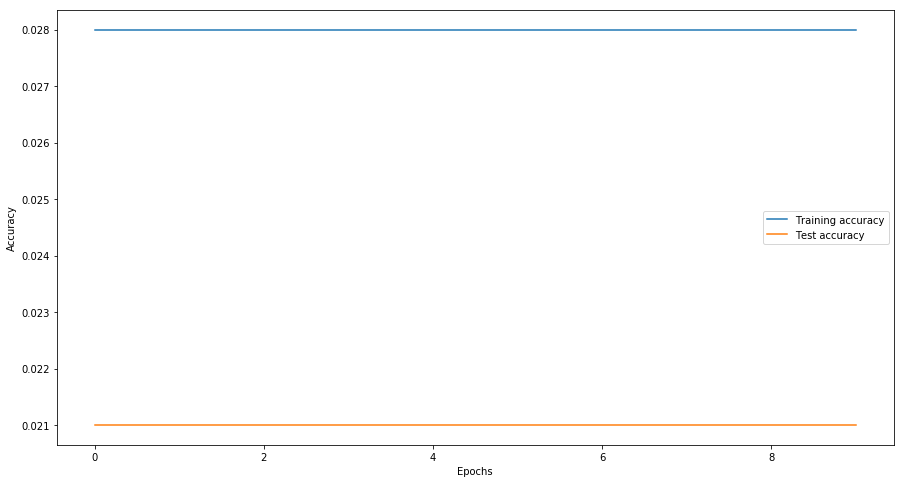

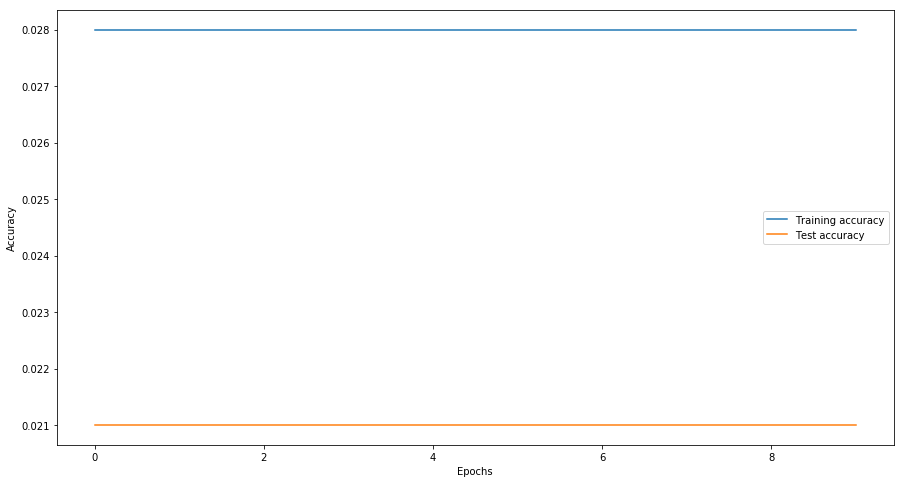

In [21]:
fig = plt.figure(figsize=(15, 8))
plt.plot(range(len(accuracy_history)), accuracy_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Test accuracy'])
fig

# Evaluation

In [22]:
evaluate('test')

C:\cosmos\envs\env1\lib\site-packages\ipykernel_launcher.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\cosmos\envs\env1\lib\site-packages\ipykernel_launcher.py:198: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.021